Mount the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**MODEL1**

Damaged car Identification

Classes : Damaged_car, Not_Damaged_car

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB3
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create generator
# generator applied random preprocessing to make the model --> robust
datagen1 = ImageDataGenerator(rescale = 1./255,
                             shear_range = 0.2,
                             # every image will be randomly distorted 0-0.2
                             zoom_range = 0.2,
                             # every image will be randomly zoomed 0-0.2
                             horizontal_flip = True, #
                             vertical_flip=True,
                             validation_split=0.1,
                             rotation_range=30)
#every image will be randomly ratated 0-30 degree
# prepare an iterators for each dataset
train_ds1= datagen1.flow_from_directory('/content/drive/MyDrive/car_dataset/training_model1',
                                       class_mode='categorical',
                                       classes=['Damaged_car', 'Not_Damaged_car'],
                                       target_size=(224, 224),
                                       batch_size=100,
                                       shuffle=True,
                                       seed=123,
                                       subset='training',

                                       )

test_ds1= datagen1.flow_from_directory('/content/drive/MyDrive/car_dataset/training_model1',
                                       class_mode='categorical',
                                       classes=['Damaged_car', 'Not_Damaged_car'],
                                       target_size=(224, 224),
                                       batch_size=100,
                                       shuffle=True,
                                       seed=123,
                                       subset='validation'
                                       )

test_datagen1 = ImageDataGenerator(rescale = 1./255,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             horizontal_flip = True,
                             vertical_flip=True,
                             rotation_range=30)

val_ds1 = test_datagen1.flow_from_directory('/content/drive/MyDrive/car_dataset/validation_model1',
                                       class_mode='categorical',
                                       classes=['Damaged_car', 'Not_Damaged_car'],
                                       target_size=(224, 224),
                                       batch_size=100,
                                       shuffle=True,
                                       seed=123)


Found 7445 images belonging to 2 classes.
Found 826 images belonging to 2 classes.
Found 909 images belonging to 2 classes.


In [ ]:
train_path="/content/drive/MyDrive/car_dataset/training_model1"
val_path="/content/drive/MyDrive/car_dataset/validation_model1"



In [ ]:
#Returns a list of files that match the given pattern(s) useful for getting number of output classes.
from glob import glob
glob(train_path+"/*")

['/content/drive/MyDrive/car_dataset/training_model1/Not_Damaged_car',
 '/content/drive/MyDrive/car_dataset/training_model1/Damaged_car']

In [ ]:
x,y = next(train_ds1)
x.shape

(100, 224, 224, 3)

x: This variable holds the batch of input data (images)

y: This variable holds the batch of corresponding labels

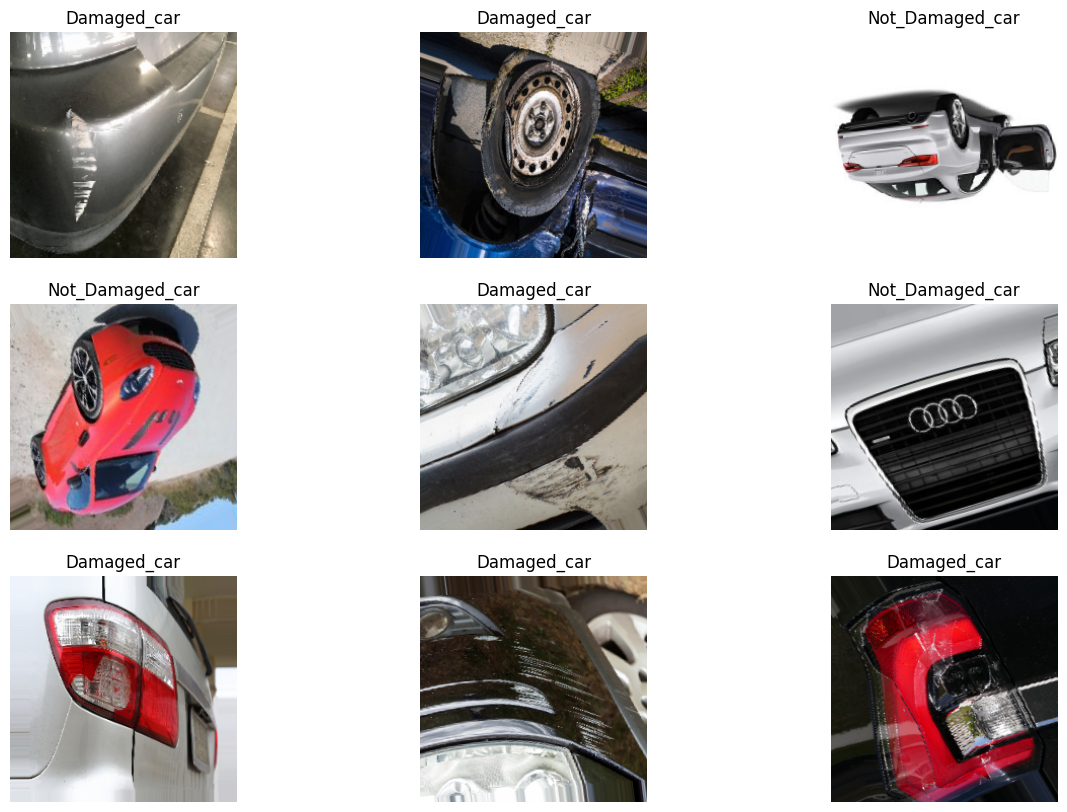

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
a = train_ds1.class_indices
class_names = list(a.keys())


def plot_images(img, labels):
    plt.figure(figsize=[15, 10])
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')

plot_images(x,y)

# VGG16 Model (Transfer Learning)

#### add preprocessing layer to the front of VGG
#### [3] add 3 Channles ie RGB
#### We are importing weights from imagenet use it as it is
#### include_top means we last layer in VGG16 Model we dont want this
#### Because with help of VGG we are tyring to solve own problem

In [ ]:
IMAGE_SIZE = [224, 224]

In [ ]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3],
            weights='imagenet',
            include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


## Don't train existing weights

In [ ]:
for layer in vgg.layers:
  layer.trainable = False

# Add Our Layers at End of VGG16

In [ ]:

# our layers - you can add more if you want
x = Flatten()(vgg.output)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
prediction = Dense(2, activation='softmax')(x)


In [ ]:
# create a model object
model_vgg = Model(inputs=vgg.input, outputs=prediction)

In [ ]:
# view the structure of the model
model_vgg.summary()

                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       295168    
                                                                 
 block3_conv2 (Conv2D)       (None, 56, 56, 256)       590080    
                                                                 
 block3_conv3 (Conv2D)       (None, 56, 56, 256)       590080    
                                                                 
 block3_pool (MaxPooling2D)  (None, 28, 28, 256)       0         
                                                                 
 block4_conv1 (Conv2D)       (None, 28, 28, 512)       1180160   
                                                                 
 block4_conv2 (Conv2D)       (None, 28, 28, 512)       2359808   
                                                                 
 block4_co

In [ ]:
model_vgg.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
import tensorflow as tf
from tensorflow import keras
early = tf.keras.callbacks.EarlyStopping( patience=4,
                                          min_delta=0.001,
                                          restore_best_weights=True)

In [ ]:
history_vgg = model_vgg.fit(train_ds1,
                    #batch_size=100,
                    validation_data=val_ds1,
                    epochs=8,
                    callbacks=[early])


Epoch 1/8
75/75 [==============================] - 1326s 17s/step - loss: 1.0114 - accuracy: 0.8492 - val_loss: 0.1937 - val_accuracy: 0.9186
Epoch 2/8
75/75 [==============================] - 189s 3s/step - loss: 0.1305 - accuracy: 0.9539 - val_loss: 0.1694 - val_accuracy: 0.9329
Epoch 3/8
75/75 [==============================] - 189s 3s/step - loss: 0.1070 - accuracy: 0.9567 - val_loss: 0.1448 - val_accuracy: 0.9505
Epoch 4/8
75/75 [==============================] - 185s 2s/step - loss: 0.0894 - accuracy: 0.9663 - val_loss: 0.1578 - val_accuracy: 0.9384
Epoch 5/8
75/75 [==============================] - 182s 2s/step - loss: 0.0931 - accuracy: 0.9652 - val_loss: 0.1556 - val_accuracy: 0.9329
Epoch 6/8
75/75 [==============================] - 179s 2s/step - loss: 0.0880 - accuracy: 0.9664 - val_loss: 0.1369 - val_accuracy: 0.9494
Epoch 7/8
75/75 [==============================] - 177s 2s/step - loss: 0.0802 - accuracy: 0.9703 - val_loss: 0.1331 - val_accuracy: 0.9450
Epoch 8/8
75/75 [=

In [ ]:
history_vgg.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

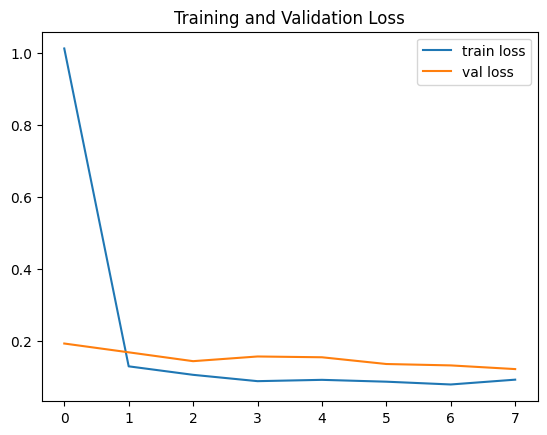

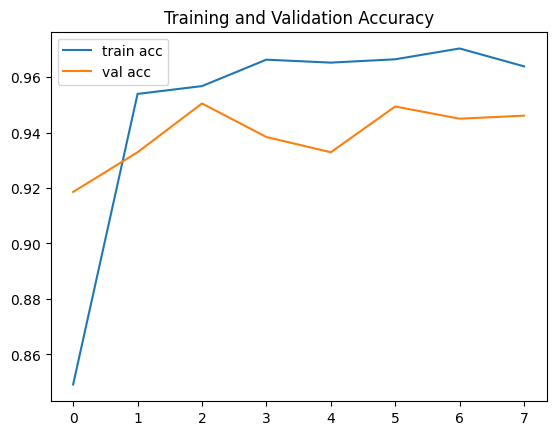

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(history_vgg.history['loss'], label='train loss')
plt.plot(history_vgg.history['val_loss'], label='val loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history_vgg.history['accuracy'], label='train acc')
plt.plot(history_vgg.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
accuracy_score = model_vgg.evaluate(test_ds1)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))

print("Loss: ",accuracy_score[0])

9/9 [==============================] - 110s 13s/step - loss: 0.0692 - accuracy: 0.9746
[0.06922503560781479, 0.9745762944221497]
Accuracy: 97.4576%
Loss:  0.06922503560781479


In [ ]:
import pickle
pickle.dump(model_vgg, open('model_vgg.pkl','wb'))

In [ ]:
# from tensorflow.keras.models import load_model
model_vgg.save('model_vgg.h5')

**MODEL2**

Car Damage Assessment

Classes : minor,moderate,severe

In [ ]:
# example of progressively loading images from file
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create generator
# generator applied random preprocessing to make the model --> robust
datagen = ImageDataGenerator(rescale = 1./255,
                             shear_range = 0.2,
                             # every image will be randomly distorted 0-0.2
                             zoom_range = 0.2,
                             # every image will be randomly zoomed 0-0.2
                             horizontal_flip = True, #
                             vertical_flip=True,
                             validation_split=0.1,
                             rotation_range=30)
#every image will be randomly ratated 0-30 degree
# prepare an iterators for each dataset
train_ds2= datagen.flow_from_directory('/content/drive/MyDrive/Car_damage/training',
                                       class_mode='categorical',
                                       classes=['01-minor', '02-moderate','03-severe'],
                                       target_size=(224, 224),
                                       batch_size=64,
                                       shuffle=True,
                                       seed=123,
                                       subset='training',

                                       )

test_ds2= datagen.flow_from_directory('/content/drive/MyDrive/Car_damage/training',
                                       class_mode='categorical',
                                       classes=['01-minor', '02-moderate','03-severe'],
                                       target_size=(224, 224),
                                       batch_size=64,
                                       shuffle=True,
                                       seed=123,
                                       subset='validation'
                                       )

test_datagen = ImageDataGenerator(rescale = 1./255,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             horizontal_flip = True,
                             vertical_flip=True,
                             rotation_range=30)

val_ds2 = test_datagen.flow_from_directory('/content/drive/MyDrive/Car_damage/testing',
                                       class_mode='categorical',
                                       classes=['01-minor', '02-moderate','03-severe'],
                                       target_size=(224, 224),
                                       batch_size=64,
                                       shuffle=True,
                                       seed=123)


Found 1293 images belonging to 3 classes.
Found 141 images belonging to 3 classes.
Found 248 images belonging to 3 classes.


In [ ]:
train_path="/content/drive/MyDrive/Car_damage/training"
val_path="/content/drive/MyDrive/Car_damage/testing"



In [ ]:
#Returns a list of files that match the given pattern(s).
from glob import glob
glob(train_path+"/*")

['/content/drive/MyDrive/Car_damage/training/03-severe',
 '/content/drive/MyDrive/Car_damage/training/01-minor',
 '/content/drive/MyDrive/Car_damage/training/02-moderate']

In [ ]:
x,y = next(train_ds2)
x.shape

(64, 224, 224, 3)

x: This variable holds the batch of input data (images)

y: This variable holds the batch of corresponding labels

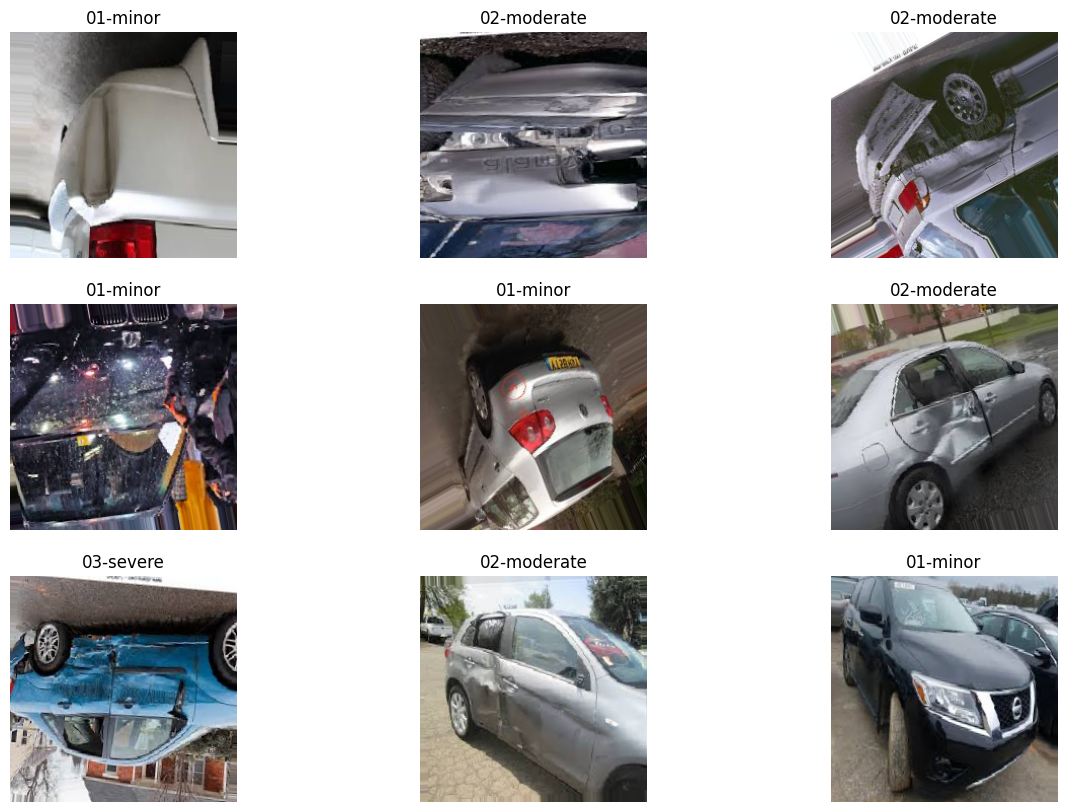

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
a = train_ds2.class_indices
class_names = list(a.keys())


def plot_images(img, labels):
    plt.figure(figsize=[15, 10])
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')

plot_images(x,y)

# VGG16 Model (Transfer Learning)

#### add preprocessing layer to the front of VGG
#### [3] add 3 Channles ie RGB
#### We are importing weights from imagenet use it as it is
#### include_top means we last layer in VGG16 Model we dont want this
#### Because with help of VGG we are tyring to solve own problem

In [ ]:
IMAGE_SIZE = [224, 224]

In [ ]:
vgg_1 = VGG16(input_shape=IMAGE_SIZE + [3],
            weights='imagenet',
            include_top=False)

## Don't train existing weights

In [ ]:
for layer in vgg_1.layers:
  layer.trainable = False

# Add Our Layers at End of VGG16

In [ ]:
output_classes = 3

In [ ]:

# our layers - you can add more if you want
x = Flatten()(vgg_1.output)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
prediction = Dense(output_classes, activation='softmax')(x)

In [ ]:
# create a model object
model_vgg_1 = Model(inputs=vgg_1.input, outputs=prediction)

In [ ]:
# view the structure of the model
model_vgg_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
model_vgg_1.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
import tensorflow as tf
from tensorflow import keras
early = tf.keras.callbacks.EarlyStopping( patience=5,
                                          min_delta=0.001,
                                          restore_best_weights=True)

In [ ]:
# batch_size=64
STEP_SIZE_TRAIN = train_ds2.n//train_ds2.batch_size
STEP_SIZE_VALID = val_ds2.n//val_ds2.batch_size

# fit model
history_vgg_1 = model_vgg_1.fit(train_ds2,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_ds2,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=15,
                    callbacks=[early])


Epoch 1/15
20/20 [==============================] - 22s 1s/step - loss: 0.7604 - accuracy: 0.6314 - val_loss: 0.6882 - val_accuracy: 0.6510
Epoch 2/15
20/20 [==============================] - 23s 1s/step - loss: 0.7910 - accuracy: 0.6103 - val_loss: 0.6678 - val_accuracy: 0.7083
Epoch 3/15
20/20 [==============================] - 22s 1s/step - loss: 0.7105 - accuracy: 0.6867 - val_loss: 0.6759 - val_accuracy: 0.7031
Epoch 4/15
20/20 [==============================] - 23s 1s/step - loss: 0.7218 - accuracy: 0.6827 - val_loss: 0.6655 - val_accuracy: 0.6875
Epoch 5/15
20/20 [==============================] - 23s 1s/step - loss: 0.7073 - accuracy: 0.6810 - val_loss: 0.7151 - val_accuracy: 0.6823
Epoch 6/15
20/20 [==============================] - 24s 1s/step - loss: 0.6841 - accuracy: 0.6998 - val_loss: 0.6764 - val_accuracy: 0.6719
Epoch 7/15
20/20 [==============================] - 22s 1s/step - loss: 0.6772 - accuracy: 0.7087 - val_loss: 0.6391 - val_accuracy: 0.6771
Epoch 8/15
20/20 [==

In [ ]:
history_vgg_1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

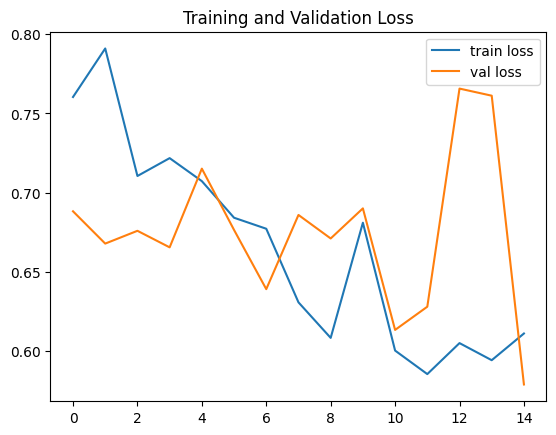

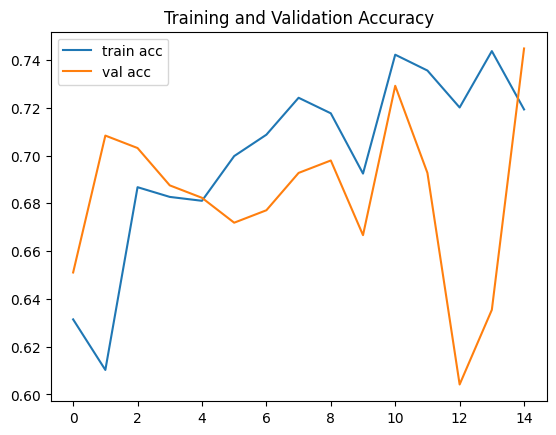

<Figure size 640x480 with 0 Axes>

In [ ]:

# plot the loss
plt.plot(history_vgg_1.history['loss'], label='train loss')
plt.plot(history_vgg_1.history['val_loss'], label='val loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history_vgg_1.history['accuracy'], label='train acc')
plt.plot(history_vgg_1.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
accuracy_score = model_vgg_1.evaluate(test_ds2)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))

print("Loss: ",accuracy_score[0])

3/3 [==============================] - 2s 458ms/step - loss: 0.7916 - accuracy: 0.6383
[0.7915624976158142, 0.6382978558540344]
Accuracy: 63.8298%
Loss:  0.7915624976158142


In [ ]:
import pickle
pickle.dump(model_vgg_1, open('model_vgg_1.pkl','wb'))

In [ ]:
 # from tensorflow.keras.models import load_model
model_vgg_1.save('model_vgg_1.h5')

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

# Load the image
img = image.load_img('/content/drive/MyDrive/Car_damage/testing/03-severe/0012.JPEG', target_size=(224, 224))

# Convert the image to a numpy array
z = image.img_to_array(img)

# Normalize the image data (scaling to values between 0 and 1)
z = z / 255.0

# Add a batch dimension to the image data
z = np.expand_dims(z, axis=0)

# Preprocess the image data for model input
img_data = preprocess_input(z)

# Make predictions using model_vgg
predictions_vgg = model_vgg.predict(img_data)

# Make predictions using model_vgg_1
predictions_vgg_1 = model_vgg_1.predict(img_data)

# Get the predicted class labels using argmax
predicted_label_vgg = np.argmax(predictions_vgg, axis=1)
predicted_label_vgg_1 = np.argmax(predictions_vgg_1, axis=1)

# Print the predicted class labels
print("Predicted label for model_vgg:", predicted_label_vgg)
print("Predicted label for model_vgg_1:", predicted_label_vgg_1)


1/1 [==============================] - 0s 18ms/step
Predicted label for model_vgg: [1]
Predicted label for model_vgg_1: [0]
